# Notebook configuration

In [168]:
run_number    = 44895
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run{}_corrections.h5".format(run_number)
inputfilename = "/Users/Gonzalo/github/NEXTdata/Th/dst_{}.root.h5".format(run_number)

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 7e5
Erange_zcorr  =  5e3, 7e5
Erange_xycorr =  9e3, 7e5
Qrange        =    0, 10e4
Frange        =  0.8, 1.2
Urange        = 1e-3, 2.5e-2

S1Erange      =    0, 1000
S1Wrange      =    0, 800
S1Hrange      =    0, 400
S2Wrange      =    0, 250
S2Hrange      =    0, 10e3
NSirange      =    0, 100

Zrange_LT     =   50, 350
Zrange_XY     =    0, 600
nX, nY, nR    =   50,  50, 50
x0, y0, r0    =   40, -40, 15 # for lifetime scan

LT_radial     = False

In [169]:
def poisson_sigma(x, default=3):
    u = x**0.5
    u[x==0] = default
    return u

# Kr analysis

In [170]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Sat Jul 15 15:21:00 2017


#### General plotting options

In [171]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [172]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

5820


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.500059e+09,0,1,250.0,44.448719,239.857872,982550.0,49.925625,21079.906250,...,1036412.5,359,53.8625,53.8625,-147.781654,-31.401422,151.080994,-2.932221,46.184242,39.012313
1,4,1.500059e+09,0,2,300.0,94.429443,535.337593,958600.0,43.535000,25391.830078,...,1030412.5,451,71.8125,71.8125,66.324339,-24.298539,70.635239,-0.351174,44.092908,44.002533
2,4,1.500059e+09,1,2,300.0,94.429443,535.337593,958600.0,38.206750,21688.212891,...,1206737.5,300,248.1375,248.1375,35.943952,-65.593366,74.796106,-1.069504,37.077952,38.925157
3,5,1.500059e+09,0,1,275.0,112.880280,659.416224,575425.0,145.523500,8349.107422,...,1085862.5,247,510.4375,510.4375,118.004499,12.010241,118.614113,0.101429,36.889561,28.377191
4,6,1.500059e+09,0,1,275.0,74.794594,421.931807,852100.0,82.078000,18348.378906,...,1019812.5,568,167.7125,167.7125,10.950268,107.701933,108.257169,1.469473,43.831121,60.067115


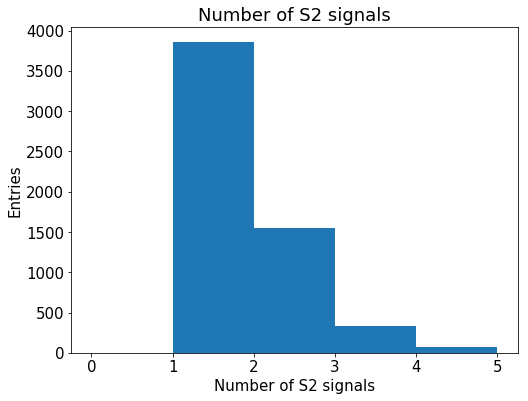

In [173]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

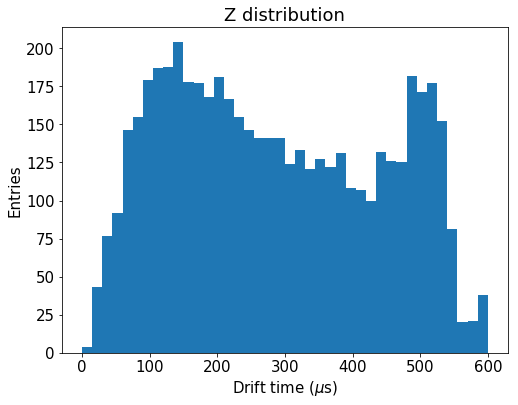

In [174]:
hist(full.Z, 40, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

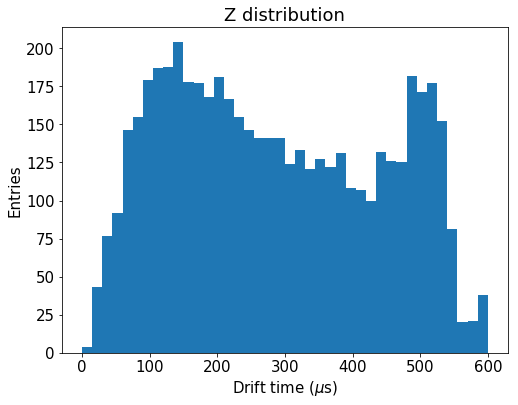

In [175]:
hist(full.Z, 40, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")


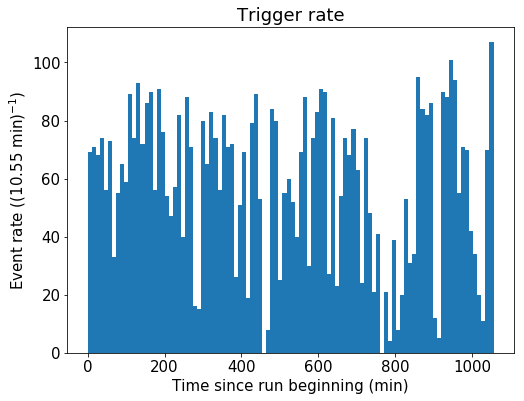

In [176]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 100, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]),
       "Trigger rate")
save("EventRate")


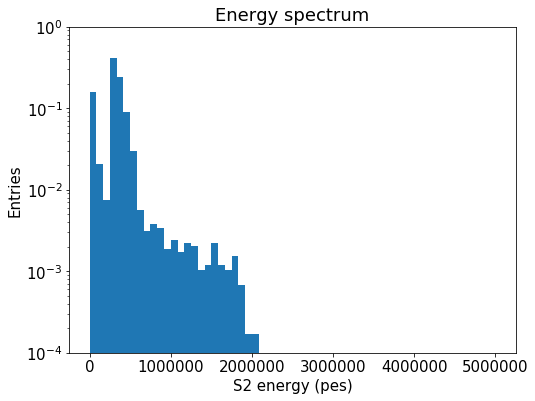

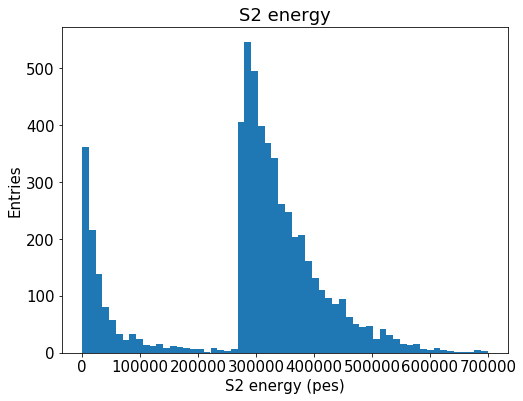

In [177]:

pdf(full.S2e, 60, (0, 50e5))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# S1 energy

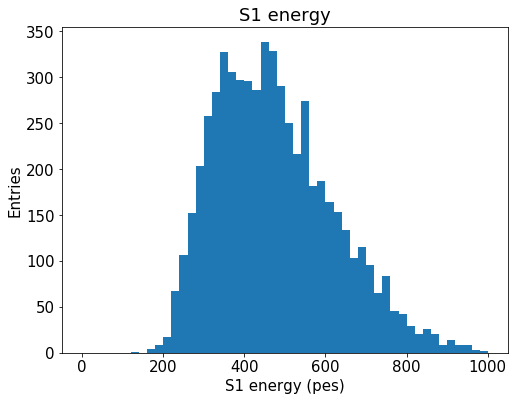

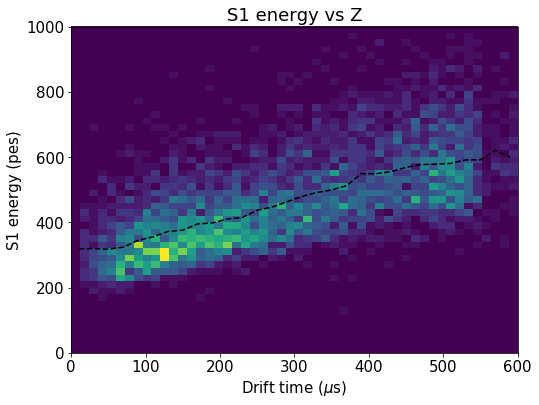

In [178]:
hist(full.S1e, 50, range=S1Erange)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full.Z, full.S1e, (50, 50), range=(Zrange, S1Erange))
x, y, _ = fitf.profileX(full.Z, full.S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

# S1 width

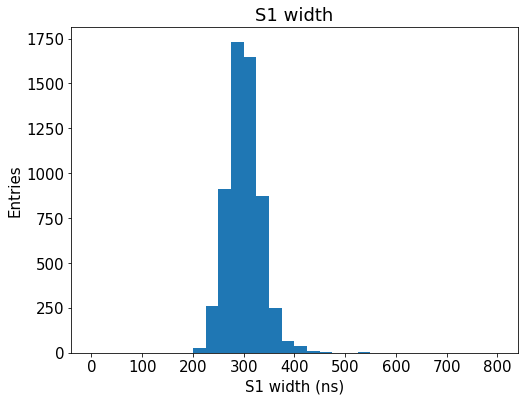

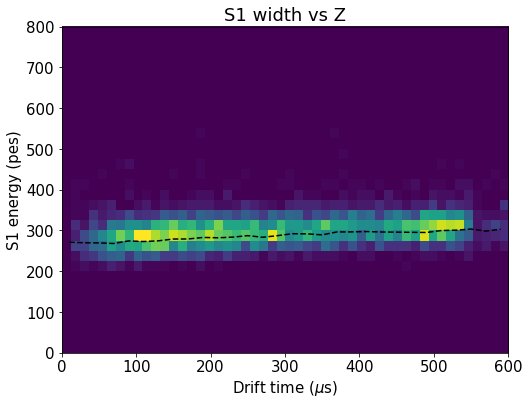

In [179]:
nb = max(S1Wrange)//25
hist(full.S1w, nb, S1Wrange)
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

hist2d(full.Z, full.S1w, (50, nb), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full.Z, full.S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 width vs Z")
save("S1widthvsZ")

# S1 height

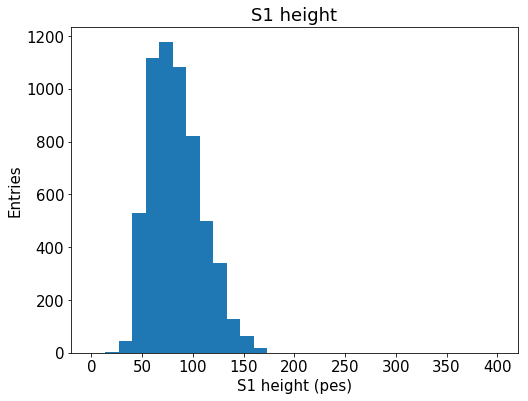

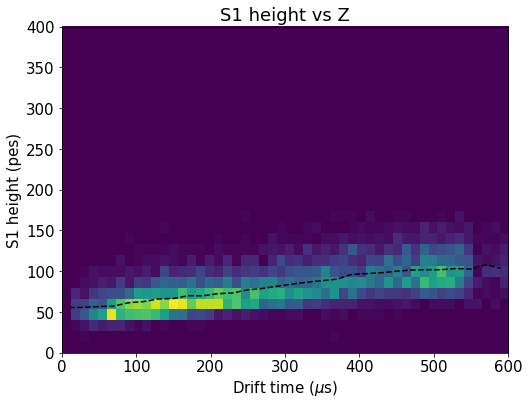

In [180]:
hist(full.S1h, 30, range=S1Hrange)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full.Z, full.S1h, (50, 30), range=(Zrange, S1Hrange))
x, y, _ = fitf.profileX(full.Z, full.S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

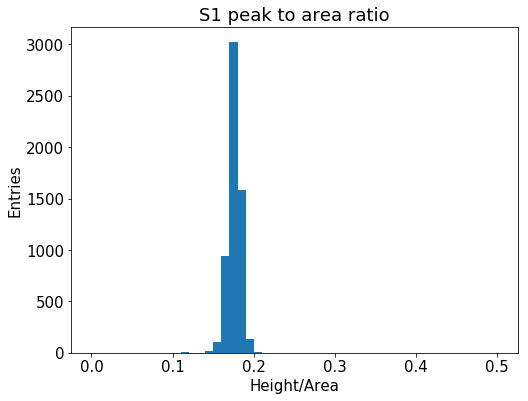

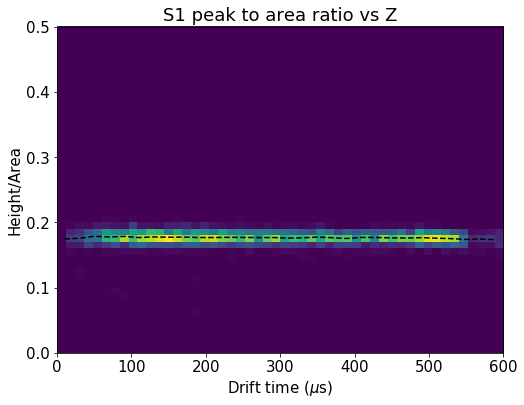

In [181]:
S1r    = full.S1h/full.S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full.Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1Peak2AreavsZ")

# S2 energy

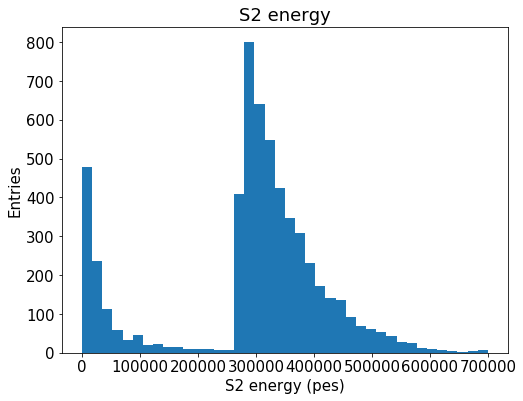

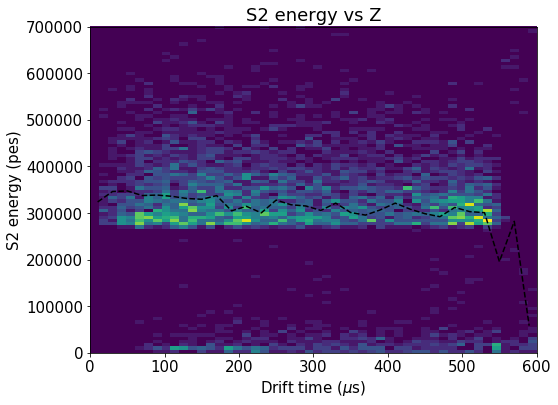

In [182]:
hist(full.S2e, 40, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# S2 width

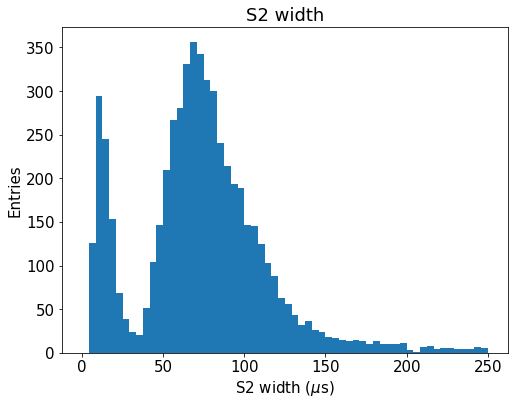

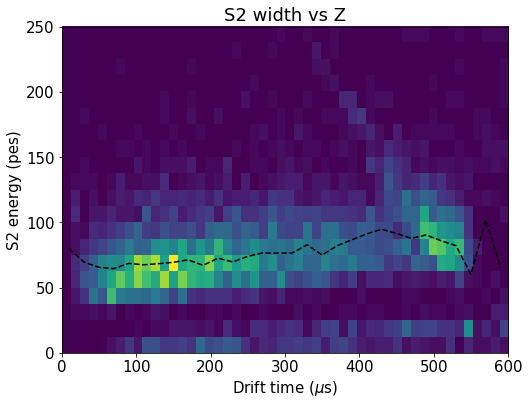

In [183]:
hist(full.S2w, 60, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full.Z, full.S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full.Z, full.S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 width vs Z")
save("S2widthvsZ")

# S2 height

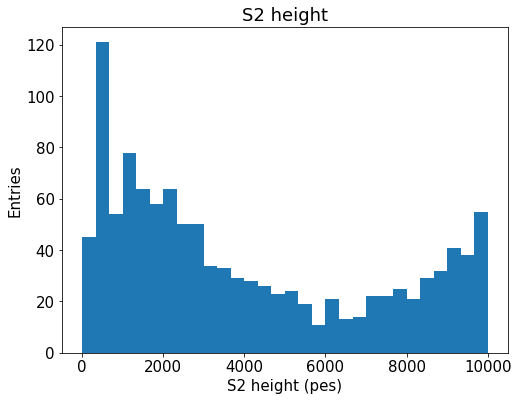

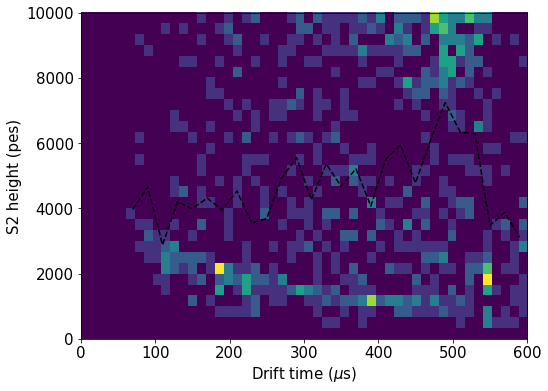

In [184]:
hist(full.S2h, 30, range=S2Hrange)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full.Z, full.S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full.Z, full.S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

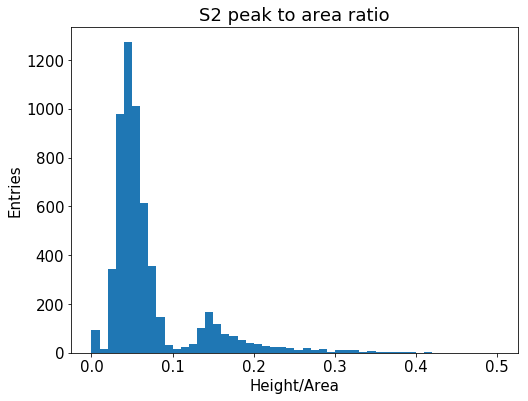

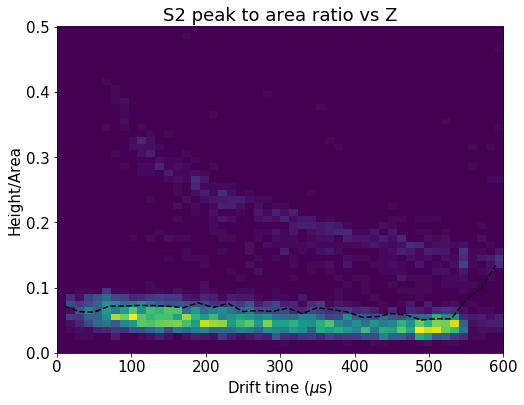

In [185]:
_range = 0, 0.5

S2r = full.S2h/full.S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full.Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2Peak2AreavsZ")

# S2 vs S1

[  2.02173866e+04   1.92986442e+10] [[ -9.99999996e-01  -8.55646535e-05]
 [  8.55646535e-05  -9.99999996e-01]]


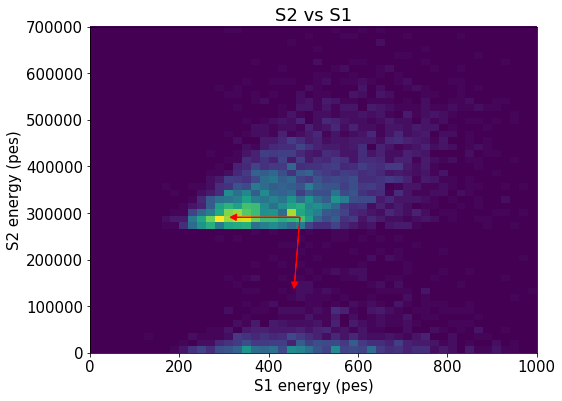

In [186]:
hist2d(full.S1e, full.S2e, (50, 50), range=(S1Erange, Erange_raw))
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)

sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)", "S2 vs S1")
save("S2vsS1")

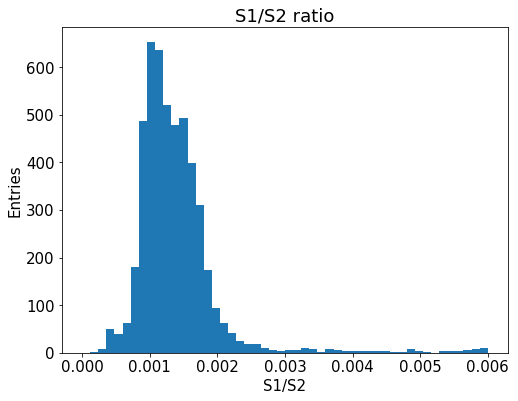

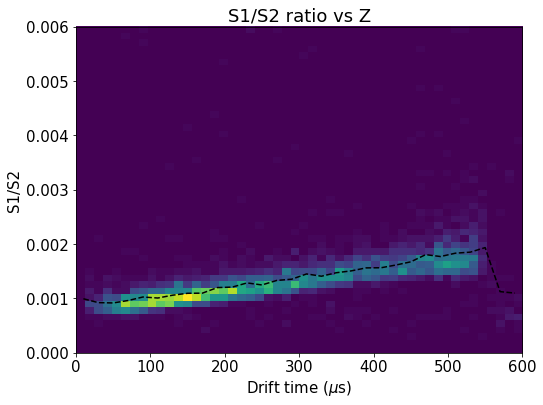

In [187]:
_range = 0, 0.006

S12r = full.S1e/full.S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full.Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

# Lifetime calculation

In [188]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.46580756013745706


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,4,1.500059e+09,0,2,300.0,94.429443,535.337593,958600.0,43.535000,25391.830078,...,1030412.5,451,71.8125,71.8125,66.324339,-24.298539,70.635239,-0.351174,44.092908,44.002533
2,4,1.500059e+09,1,2,300.0,94.429443,535.337593,958600.0,38.206750,21688.212891,...,1206737.5,300,248.1375,248.1375,35.943952,-65.593366,74.796106,-1.069504,37.077952,38.925157
6,9,1.500059e+09,0,1,300.0,52.335251,302.189005,939950.0,62.950000,15929.367188,...,1036287.5,309,96.3375,96.3375,-49.125302,16.374236,51.782342,2.819858,37.711886,38.391839
7,11,1.500059e+09,0,2,325.0,120.953362,656.717708,967425.0,114.458500,23137.507812,...,1089087.5,949,121.6625,121.6625,-81.691645,21.391497,84.445965,2.885486,66.483959,66.200088
9,13,1.500059e+09,0,1,300.0,52.880562,311.574312,918025.0,66.144125,18879.455078,...,1023387.5,369,105.3625,105.3625,47.225745,59.386186,75.874832,0.898970,41.497977,42.708980


In [189]:
xycorr = dstf.load_xy_corrections("run4446_corrections.h5")

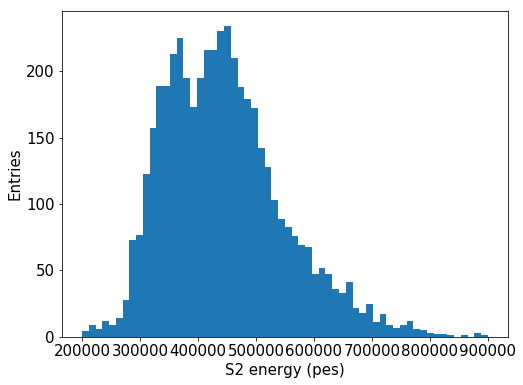

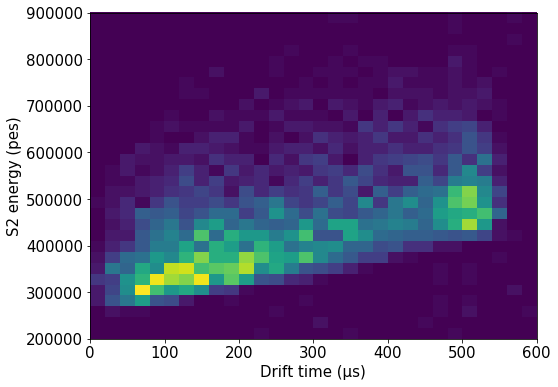

In [233]:
sel  = np.ones_like(full.Z.values, dtype=bool)
#sel  = full.nS2 == 2
#sel = (full.Z.values > 400) & (full.nS2==1) & (full.Z.values < 600)
#sel = (full.Z.values > 400)
#sel = (full.Z.values < 400)
#sel = coref.in_range(full.Z.values, 400, 600)

hist(full[sel].S2e.values\
     * np.exp(full[sel].Z.values/1050)\
     * xycorr(full[sel].X.values, full[sel].Y.values).value,
     60, (200e3, 900e3))
labels("S2 energy (pes)", "Entries")

hist2d(full[sel].Z  .values,
       full[sel].S2e.values\
       * np.exp(full[sel].Z.values/1050)\
       * xycorr(full[sel].X.values, full[sel].Y.values).value,
     30, ((0,600),(200e3, 900e3)))
labels("Drift time (µs)", "S2 energy (pes)")

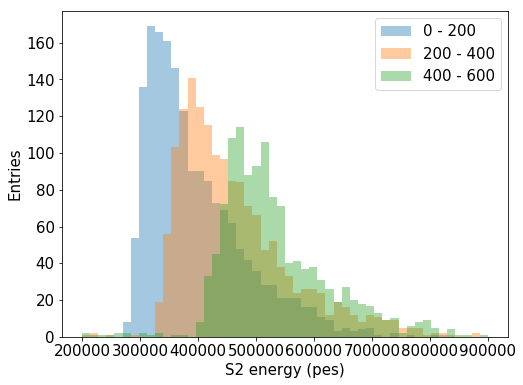

In [202]:
for i in range(3):
    sel = coref.in_range(full.Z.values, 200*i, 200*(i+1))
    plt.hist(full[sel].S2e.values\
             * np.exp(full[sel].Z.values/1050)\
,#             * xycorr(full[sel].X.values, full[sel].Y.values).value,
             50, (200e3, 900e3), alpha=0.4, label = "{} - {}".format(200*i, 200*(i+1)))
plt.legend()
labels("S2 energy (pes)", "Entries")

(Measurement(value=26.727261570835253, uncertainty=19.718643264107847), Measurement(value=21.563711660713548, uncertainty=15.909117234504803))


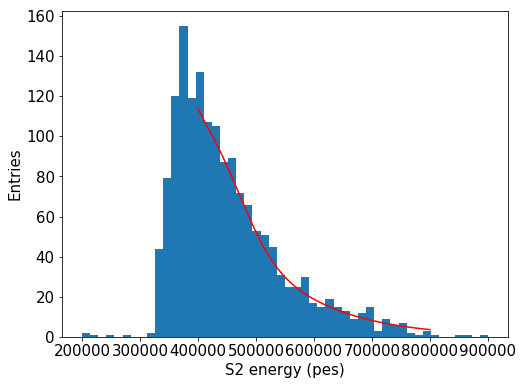

In [192]:
sel = coref.in_range(full.Z.values, 200, 400)
y, x, _ = \
plt.hist(full[sel].S2e.values\
         * np.exp(full[sel].Z.values/1150)\
,#        * xycorr(full[sel].X.values, full[sel].Y.values).value,
          50, (200e3, 900e3))

fun = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.expo(x, *args[3:])
seed = 1e6, 450e3, 1e4, 1e3, -1e5
f = fitf.fit(fun, x, y, seed, fit_range=(400e3, 800e3))
#plt.plot(x, fun(x, *seed), fitOpt)
x = np.linspace(400e3, 800e3, 200)
plt.plot(x, f.fn(x), fitOpt)
labels("S2 energy (pes)", "Entries")
print(resolution(f.values, f.errors, 1600))

###### S2 energy fiducialized

Energy at z=0 = 10358.1 +- inf
Lifetime      = 5651.5 +- inf
Chi2          = 349.76          


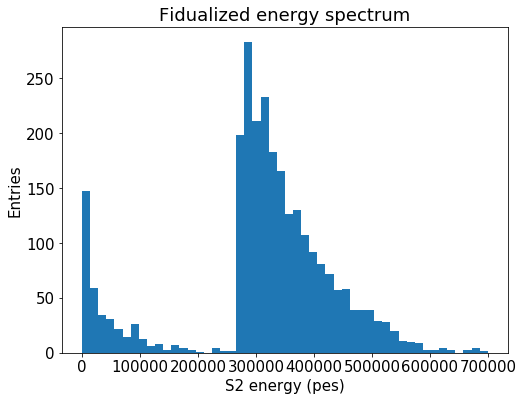

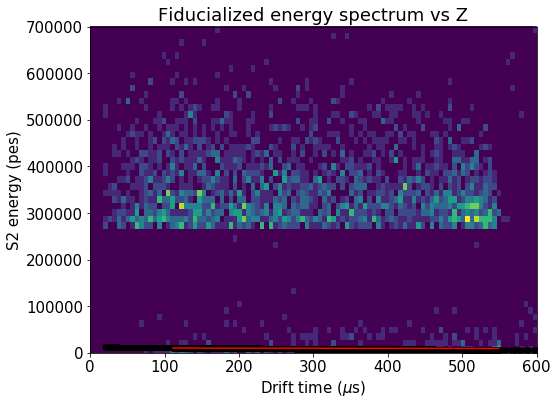

In [193]:
hist(fid.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   = 11000 * np.exp(-0.0016*fid.Z.values)
high_cut  = 14000 * np.exp(-0.0009*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, Erange_raw))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

plt.plot(x, y, profOpt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Lifetime scan

In [ ]:
x0, y0, r0 = 40, -40, 15
sel  = ((full.X - x0)**2 +
        (full.Y - y0)**2) < r0**2
data = full[sel]

low_cut   = 12000 * np.exp(-0.0010*data.Z.values)
high_cut  = 14000 * np.exp(-0.0008*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

Z = data.Z  .values[sel]
E = data.S2e.values[sel]
x, y, u_y = fitf.profileX(Z, E, 100, xrange=Zrange, yrange=Erange_raw)
f = fitf.fit(fitf.expo, x, y, (13e3, -1e3), fit_range=(50, 400), sigma=u_y)

hist2d(data.Z, data.S2e, 100, (Zrange, Erange_raw))
plt.plot(x, y, profOpt)
plt.plot(x, f.fn(x),  fitOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

labels("Drift time (µs)", "S2 energy")


lts   = np.linspace(-f.values[1] - 5*f.errors[1],
                    -f.values[1] + 5*f.errors[1],
                    20)
sigs  = (lts + f.values[1]) / f.errors[1] 
res   = np.zeros_like(lts)
u_res = np.zeros_like(lts) 
for i in range(len(lts)):
    Ecorr    = E * np.exp(Z/lts[i])
    y, x     = np.histogram(Ecorr, 50, (11e3, 15e3))
    x        = shift_to_bin_centers(x)
    f        = fitf.fit(fitf.gauss, x, y, (1e5, 13e3, 1e2), fit_range=(12500, 13500), sigma=poisson_sigma(y))
    R        = resolution(f.values, f.errors)[0]
    res[i]   = R.value
    u_res[i] = R.uncertainty

plt.figure()
plt.errorbar(lts, res, u_res)
labels("Lifetime (µs)", "Resolution")

res_ticks = plt.yticks()[0]
xax = plt.gca().twiny()
yax = plt.gca().twinx()


xax.set_xlim(min(sigs), max(sigs))
xax.set_xticks(range(-5,6,2))
xax.set_xlabel("Deviation from fit (#$\sigma$)")

scale = (41.5/2458)**0.5
yax.set_ylim(min(res) * scale, max(res) * scale)
#yax.set_yticks(res_ticks * scale)
yax.set_ylabel("Resolution @ Qbb")

# Lifetime vs R

In [ ]:
rbins  = np.array([0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190])
nbins  = len(rbins) - 1
nx, ny = 4, 3

LT     = np.zeros(nbins)
u_LT   = np.zeros(nbins)

Z = full.Z  .values
R = full.R  .values
E = full.S2e.values

plt.figure(figsize=(6*nx, 6*ny))

for i in range(nbins):
    sel_r = coref.in_range(E, *Erange_raw) & coref.in_range(R, *rbins[i:i+2])
    
    plt.subplot(nx, ny, i+1)
    n, x, y, _ = \
    hist2d(Z[sel_r], E[sel_r], (40, 50), (Zrange, Erange_raw), new_figure=False)
    labels("Drift time (µs)", "S2 energy (pes)", "{:.0f} - {:.0f} mm".format(*rbins[i:i+2]))
    slice_max = np.argmax(n, axis=1)
    slice_ene = y[slice_max]
    slice_rms = [1.25*np.average((y-mean)**2, weights=w)**0.5 if np.any(w) else 0 for w, mean in zip(n, slice_ene)]
    
    plt.errorbar(x, slice_ene, slice_rms, fmt="*k")
    
    f_low = fitf.fit(fitf.expo, x, slice_ene-slice_rms, (1e4, -500), fit_range=Zrange_LT)
    f_upp = fitf.fit(fitf.expo, x, slice_ene+slice_rms, (1e4, -500), fit_range=Zrange_LT)
    
    plt.plot(x, f_low.fn(x), "r")
    plt.plot(x, f_upp.fn(x), "r")

    low_cut = f_low.fn(Z)
    upp_cut = f_upp.fn(Z)
    sel_E   = coref.in_range(E, low_cut, upp_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(Z[sel_r & sel_E], E[sel_r & sel_E], 100, xrange=Zrange, yrange=Erange_raw)
    plt.errorbar(x, y, u_y, fmt="*m")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    LT  [i] = -f.values[1]
    u_LT[i] =  f.errors[1]
plt.tight_layout()

dr    = np.diff(rbins) * 0.5
rbins = rbins[:-1] + dr 
plt.figure()
plt.errorbar(rbins, LT, u_LT, dr, fmt="k*")

seed = (LT[0], 1e-2, 100)
func = lambda x, a=0, b=0, c=0, d=0: a - b*x*np.exp(x/c)
f = fitf.fit(func, rbins, LT, seed, sigma=u_LT)
plt.plot(rbins, f.fn(rbins), "-r")
labels("R (mm)", "Lifetime (µs)", "Lifetime vs R")
save("LifetimevsR")

print("Lifetime = ", "({0:.1f} +- {3:.1f}) - ({1:.3f} +- {4:.3f}) x exp[x/({2:.1f} +- {5:.1f})]".format(*f.values, *f.errors))
print("Chi2 =", f.chi2)
Zcorr_R = corrf.LifetimeRCorrection(f.values, f.errors)

# Correction by attachment

In [ ]:
correction = Zcorr(fid.Z.values, fid.R.values) if LT_radial else\
             Zcorr(fid.Z.values)
Efid_zcorr = fid.S2e.values * correction.value

y, x, _ = hist(Efid_zcorr, 100, range=Erange_zcorr)

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3])
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(12400, 14000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_zcorr[0], 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("EcorrZ_fiducial")

hist2d(fid.Z.values, Efid_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("EcorrZvsZ_fiducial")

# Tracking

In [ ]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Kr distribution

In [ ]:
correction = Zcorr(full.Z.values, full.R.values) if LT_radial else\
             Zcorr(full.Z.values)

E_zcorr = full.S2e.values * correction.value
sel     = coref.in_range(E_zcorr, 10e3, 14e3)
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

In [ ]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

In [ ]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

In [ ]:
_, _, cb = hist2d_profile(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

_, _, cb = hist2d_profile(Kr.R, Kr.Phi, full.S2q, nX, nY, Rrange, Prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [ ]:
sel = coref.in_range(Kr.Z.values, *Zrange_XY)

(xc, yc, Ec, Ece), _, cb = \
hist2d_profile(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

_, _, cb = hist2d_profile(Kr.R.values, Kr.Phi.values, E_zcorr, nX, nY, Rrange, Prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R, E_zcorr, (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values, E_zcorr, 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi, E_zcorr, (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values, E_zcorr, 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr    = corrf.Correction((xc, yc), Ec, Ece, "index", index=(12, 12))
corr_file = tb.open_file(corr_filename, "w")
dstio.xy_writer(corr_file)(*XYcorr._xs, XYcorr._fs, XYcorr._us, nXY)
corr_file.close()
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr._fs==1)[0])]))

# Correction map

In [ ]:
_x = np.repeat(xc, yc.size)
_y = np.tile  (yc, xc.size)
_r = (_x**2 + _y**2)**0.5
_f = XYcorr._fs.flatten()
_u = XYcorr._us.flatten()

hist2d(_x, _y, (nX, nY), (XYrange, XYrange), weights=_f)
labels("x (mm)", "y (mm)", "Correction map")
plt.colorbar().set_label("Correction factor")
save("CorrectionMap")

hist2d(_x, _y, (nX, nY), (XYrange, XYrange), weights=_u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
plt.colorbar().set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

# Correction by attachment and position

In [ ]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

y, x, _ = hist(E_xyzcorr, 80, Erange_xycorr)

fun  = fitf.gauss
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_xycorr[0], 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

_, _, cb = hist2d_profile(Kr.X.values, Kr.Y.values, E_xyzcorr, 50, 50, XYrange, XYrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "XYZ-corrected energy vs XY")
save("EcorrZXYvsXY")

_, _, cb = hist2d_profile(Kr.R.values, Kr.Phi.values, E_xyzcorr, 50, 50, Rrange, Prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "XYZ-corrected energy vs R$\phi$")
save("EcorrZXYvsRPhi")

hist2d(Kr.R.values, E_xyzcorr, (50, 50), range=(Rrange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.R.values, E_xyzcorr, 50, Rrange, Erange_xycorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)", "XYZ-corrected energy vs R")
save("EcorrZXYvsR")

hist2d(Kr.Phi.values, E_xyzcorr, (50, 50), range=(Prange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.Phi.values, E_xyzcorr, 50, xrange=Prange, yrange=Erange_xycorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)", "XYZ-corrected energy vs $\phi$")
save("EcorrZXYvsPhi")

In [ ]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, (10e3, 13e3)))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

In [ ]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

y, x, _ = hist(E_xyztcorr, 80, Erange_xycorr)

fun  = fitf.gauss
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

In [ ]:
sel_z  = coref.in_range(Kr.Z.values, 0, 100)
sel_r  = coref.in_range(Kr.R.values, 0, 100)
sel_zr = sel_z & sel_r

y, x, _ = hist(E_xyztcorr[sel_r], 80, Erange_xycorr)

fun  = fitf.gauss
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial")
save("EcorrZXYT_fiducial")


y, x, _ = hist(E_xyztcorr[sel_z], 80, Erange_xycorr)

fun  = fitf.gauss
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy short drift")
save("EcorrZXYT_short_drift")


y, x, _ = hist(E_xyztcorr[sel_zr], 80, Erange_xycorr)

fun  = fitf.gauss
seed = 1e3, 12000, 100
low  =  10, 11000,  50
upp  = 1e8, 13000, 900
f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial short drift")
save("EcorrZXYT_fiducial_short_drift")

In [ ]:
Rbins = [0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190]
nbins = len(Rbins) - 1
r     = shift_to_bin_centers(Rbins)
dr    = 0.5 * np.diff       (Rbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 4, i+1)
    
    sel = coref.in_range(Kr.R.values, *Rbins[i:i+2]) & sel_z
    y, x, _ = hist(E_xyztcorr[sel], 80, Erange_xycorr, new_figure=False)

    fun  = fitf.gauss
    seed = 1e3, 12000, 100
    low  =  10, 11000,  50
    upp  = 1e8, 13000, 900
    f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp))

    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Rbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Rslices")

plt.figure()
plt.errorbar(r, R, u_R, dr, "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionvsR")

In [ ]:
Zbins = np.linspace(0, 450, 10)
nbins = len(Zbins) - 1
z     = shift_to_bin_centers(Zbins)
dz    = 0.5 * np.diff       (Zbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 3, i+1)
    
    sel = coref.in_range(Kr.Z.values, *Zbins[i:i+2]) & sel_r
    y, x, _ = hist(E_xyztcorr[sel], 80, Erange_xycorr, new_figure=False)

    fun  = fitf.gauss
    seed = 1e3, 12000, 100
    low  =  10, 11000,  50
    upp  = 1e8, 13000, 900
    f    = fitf.fit(fun, x, y, seed, fit_range=(11000, 13000), bounds=(low, upp))

    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Zbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Zslices")

plt.figure()
plt.errorbar(z, R, u_R, dz, "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
print("Resolutions", Rbb)
save("ResolutionvsZ")